In [200]:
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from datetime import datetime

### Data preprocessing


In [201]:
path = 'archive-2/architectural-styles-dataset'

BATCH_SIZE = 32 
IMG_SIZE = 160
epochs = 10

In [202]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,   
    shuffle=True, 
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE)
    
)

Found 10113 files belonging to 25 classes.
Using 8091 files for training.


In [203]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    path, 
    validation_split=0.2,
    subset="validation",
    seed=123,   
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE)
    
)

Found 10113 files belonging to 25 classes.
Using 2022 files for validation.


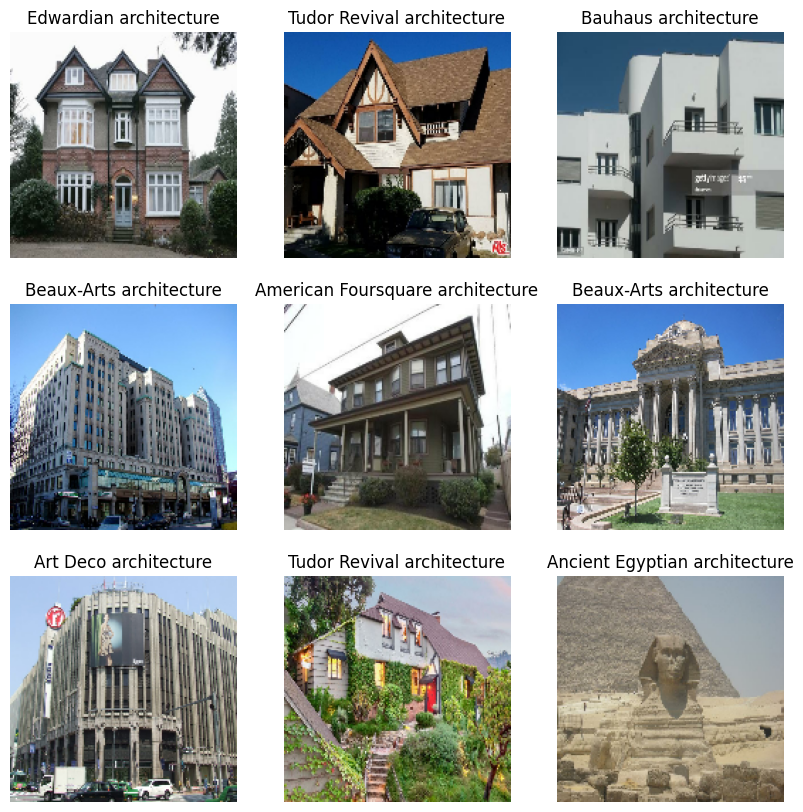

In [204]:
# Visulaize some of the images
class_names = train_ds.class_names
num_classes = len(class_names)

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [205]:
# Convert integer labels to binary matrix
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

In [206]:
# create testset 
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 52
Number of test batches: 12


In [207]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE) 
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# These lines speeds up the training process. Caching ensures that we don't have to reload the data every time we use it.
# Prefetching ensures that we always have the next batch of data ready to go. 

In [208]:
# Data augumentation

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2)
])

In [209]:
# Rescale pixel values 
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# preprocess_input is used to preprocess input images in the same way that the MobileNetV2 was trained 

### Create base model

In [210]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(
                                        input_shape=IMG_SHAPE,
                                        include_top=False,
                                        weights='imagenet',
                                        )

# We load a network that doesn't include the classification layers on the top (include_top=False)

In [211]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

### Feature extraction

In [212]:
# Freeze the convolutional base 
base_model.trainable = False

In [213]:
# Add classification head

global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # convert the features to a single 1280-element vector per image.
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(25, activation='softmax') 
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 25)


In [214]:
# Build the model 
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [215]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)

In [216]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [217]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

### Train the model

In [218]:
initial_epochs = 20
loss0, accuracy0 = model.evaluate(val_ds)

52/52 [==============================] - 19s 302ms/step - loss: 3.7434 - accuracy: 0.0379


In [220]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/20
253/253 [==============================] - 100s 393ms/step - loss: 2.0835 - accuracy: 0.3623 - val_loss: 2.0225 - val_accuracy: 0.3926
Epoch 2/20
253/253 [==============================] - 99s 390ms/step - loss: 1.9937 - accuracy: 0.3940 - val_loss: 1.9617 - val_accuracy: 0.4096
Epoch 3/20
253/253 [==============================] - 100s 392ms/step - loss: 1.9327 - accuracy: 0.4090 - val_loss: 1.9233 - val_accuracy: 0.4127
Epoch 4/20
253/253 [==============================] - 100s 395ms/step - loss: 1.8770 - accuracy: 0.4266 - val_loss: 1.8729 - val_accuracy: 0.4286
Epoch 5/20
  8/253 [..............................] - ETA: 1:47 - loss: 1.7232 - accuracy: 0.4805

KeyboardInterrupt: 

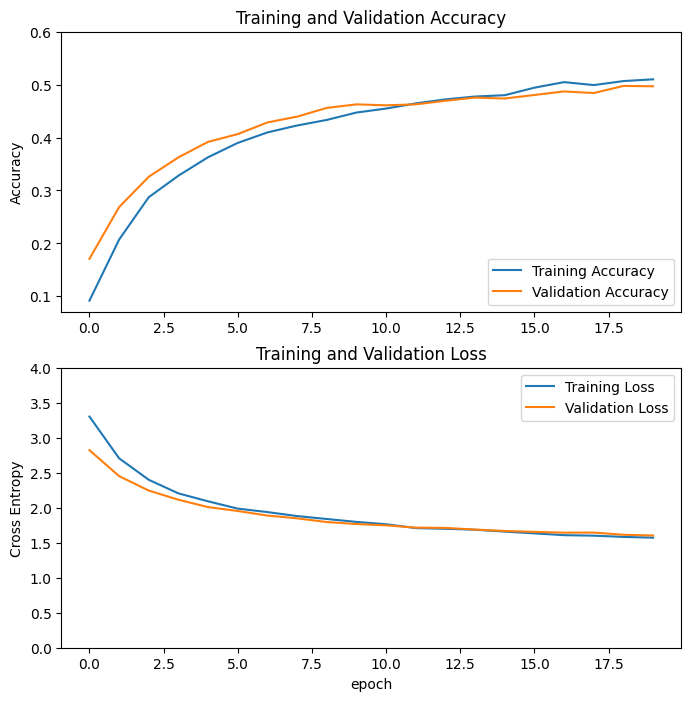

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.6])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning

In [ ]:
# Un-freeze top layers 
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer
fine_tune_at = 100

# Freeze all layers before the fine_tune_at' layer 
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [ ]:
# compile model 

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [ ]:
len(model.trainable_variables)

158

In [ ]:
# Continue training the model

fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 20/25
253/253 [==============================] - 316s 1s/step - loss: 1.5318 - accuracy: 0.5226 - val_loss: 1.5320 - val_accuracy: 0.5275
Epoch 21/25
253/253 [==============================] - 306s 1s/step - loss: 1.4382 - accuracy: 0.5438 - val_loss: 1.5117 - val_accuracy: 0.5299
Epoch 22/25
253/253 [==============================] - 299s 1s/step - loss: 1.3777 - accuracy: 0.5688 - val_loss: 1.4223 - val_accuracy: 0.5531
Epoch 23/25
253/253 [==============================] - 303s 1s/step - loss: 1.3258 - accuracy: 0.5798 - val_loss: 1.4263 - val_accuracy: 0.5604
Epoch 24/25
253/253 [==============================] - 311s 1s/step - loss: 1.2707 - accuracy: 0.5951 - val_loss: 1.4188 - val_accuracy: 0.5598
Epoch 25/25
253/253 [==============================] - 306s 1s/step - loss: 1.2249 - accuracy: 0.6133 - val_loss: 1.3830 - val_accuracy: 0.5745


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

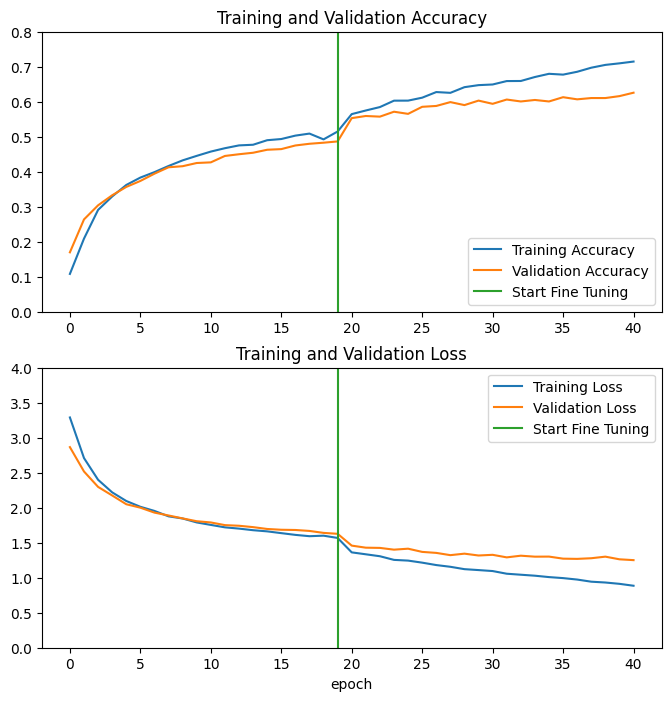

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 0.8])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### Evaluation 

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

12/12 [==============================] - 4s 319ms/step - loss: 1.1302 - accuracy: 0.6745
Test accuracy : 0.6744791865348816


Predictions:
 [ 5 17 21  6 19  7 10 21  5 24 20 11  8  0 12 21 21 21 21  3  5  4  4  6
 18 22  5 23 24  0  5  5]
Labels:
 [21 17 21 13 19 17  4 21  5 24 17 11  8  0 12 21  1 21 21  3  8  4  4  6
 18 22 10 23 24  6  8 13]
Predictions:
 ['Art Nouveau architecture', 'International style', 'Queen Anne architecture', 'Baroque architecture', 'Palladian architecture', 'Bauhaus architecture', 'Chicago school architecture', 'Queen Anne architecture', 'Art Nouveau architecture', 'Tudor Revival architecture', 'Postmodern architecture', 'Colonial architecture', 'Beaux-Arts architecture', 'Achaemenid architecture', 'Deconstructivism', 'Queen Anne architecture', 'Queen Anne architecture', 'Queen Anne architecture', 'Queen Anne architecture', 'Ancient Egyptian architecture', 'Art Nouveau architecture', 'Art Deco architecture', 'Art Deco architecture', 'Baroque architecture', 'Novelty architecture', 'Romanesque architecture', 'Art Nouveau architecture', 'Russian Revival architecture', 'Tudor Revival a

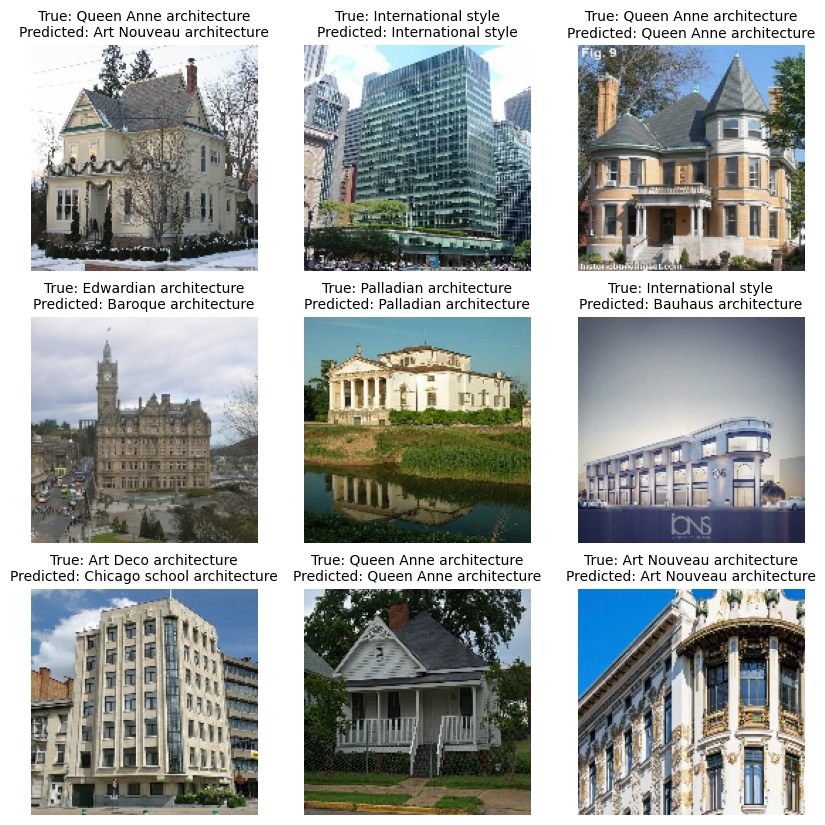

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()

# Get predictions for the batch of images
predictions = model.predict_on_batch(image_batch)

# Convert the predictions to class labels using argmax
predicted_labels = tf.argmax(predictions, axis=1)

# Convert one-hot encoded labels to class labels using argmax
true_labels = tf.argmax(label_batch, axis=1)

print('Predictions:\n', predicted_labels.numpy())
print('Labels:\n', true_labels.numpy())

# Convert integer labels to string labels using the class_names list
predicted_labels = [class_names[label] for label in predicted_labels.numpy()]
true_labels = [class_names[label] for label in true_labels.numpy()]

print('Predictions:\n', predicted_labels)
print('Labels:\n', true_labels)


plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  #plt.title(class_names[predicted_labels[i]])
  plt.title(f"True: {true_labels[i]}\nPredicted: {predicted_labels[i]}", fontsize=10)
  plt.axis("off")


In [ ]:
# Get the top K predictions for the batch of images
top_k = 5
values, indices = tf.math.top_k(predictions, k=top_k)

# Convert the predicted and true labels to string labels using the class_names list
predicted_labels = [class_names[index] for index in tf.argmax(predictions, axis=1)]
true_labels = [class_names[index] for index in tf.argmax(label_batch, axis=1)]

# Print the top K predicted labels for each image
for i in range(len(image_batch)):
    print(f"\nImage {i} - True label: {true_labels[i]}")
    print("Predicted labels:")
    for j in range(top_k):
        pred_class = class_names[indices[i][j]]
        pred_prob = values[i][j].numpy()
        print(f"  {pred_class}: {pred_prob:.2f}")


Image 0 - True label: Queen Anne architecture
Predicted labels:
  Art Nouveau architecture: 0.35
  Tudor Revival architecture: 0.32
  Queen Anne architecture: 0.18
  Russian Revival architecture: 0.04
  Edwardian architecture: 0.03

Image 1 - True label: International style
Predicted labels:
  International style: 0.94
  Deconstructivism: 0.05
  Postmodern architecture: 0.01
  Art Deco architecture: 0.00
  Bauhaus architecture: 0.00

Image 2 - True label: Queen Anne architecture
Predicted labels:
  Queen Anne architecture: 1.00
  Edwardian architecture: 0.00
  American craftsman style: 0.00
  Tudor Revival architecture: 0.00
  Colonial architecture: 0.00

Image 3 - True label: Edwardian architecture
Predicted labels:
  Baroque architecture: 0.35
  Edwardian architecture: 0.31
  Art Nouveau architecture: 0.13
  Tudor Revival architecture: 0.06
  Beaux-Arts architecture: 0.03

Image 4 - True label: Palladian architecture
Predicted labels:
  Palladian architecture: 0.77
  Colonial archit

In [ ]:
true_labels = []
for i in range(len(image_batch)):
    class_idx = tf.argmax(label_batch[i])
    true_labels.append(class_names[class_idx])


Image 0 - True label: Edwardian architecture
Predicted labels:
  Edwardian architecture: 0.57
  Queen Anne architecture: 0.36
  American Foursquare architecture: 0.04
  Art Nouveau architecture: 0.01
  Georgian architecture: 0.01

Image 1 - True label: Russian Revival architecture
Predicted labels:
  Byzantine architecture: 0.32
  Colonial architecture: 0.25
  Edwardian architecture: 0.16
  Russian Revival architecture: 0.10
  Baroque architecture: 0.07

Image 2 - True label: Ancient Egyptian architecture
Predicted labels:
  Ancient Egyptian architecture: 0.97
  Achaemenid architecture: 0.03
  Novelty architecture: 0.00
  Romanesque architecture: 0.00
  Byzantine architecture: 0.00

Image 3 - True label: Queen Anne architecture
Predicted labels:
  Queen Anne architecture: 0.75
  Edwardian architecture: 0.15
  Colonial architecture: 0.03
  American craftsman style: 0.01
  Art Nouveau architecture: 0.01

Image 4 - True label: Edwardian architecture
Predicted labels:
  Art Nouveau archit

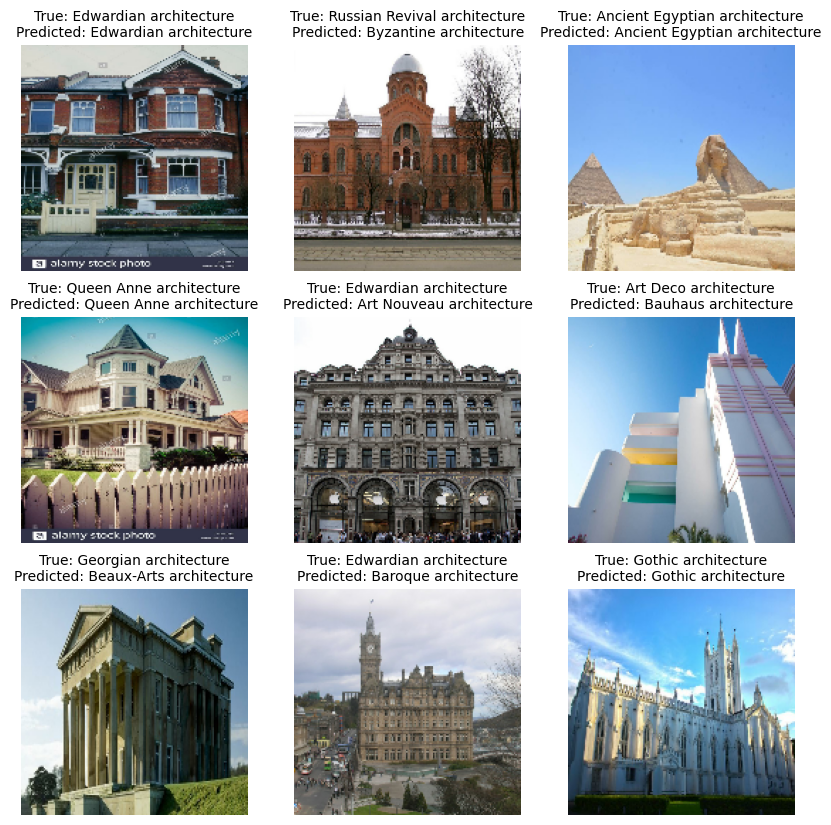

In [ ]:
top_k = 5
values, indices = tf.math.top_k(predictions, k=top_k)
for i in range(len(image_batch)):
    print(f"\nImage {i} - True label: {true_labels[i]}")
    print("Predicted labels:")
    for j in range(top_k):
        pred_class = class_names[indices[i][j]]
        pred_prob = values[i][j].numpy()
        print(f"  {pred_class}: {pred_prob:.2f}")



plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"True: {true_labels[i]}\nPredicted: {predicted_labels[i][0]}", fontsize=10)
    plt.axis("off")
plt.show()